# Protein-Metabolite Co-Expression Network Analysis

## Objective
Using the integrated multi-omics dataset, identify which specific proteins function as central network hubs in a protein-metabolite co-expression network constructed to link the 'insulin-resistance-associated triglycerides' with proteomic abundances in participants exhibiting low beta-cell function.

## Background
This analysis integrates:
1. **Proteomics data** (Olink platform) - protein abundances
2. **Metabolomics data** - metabolite abundances, focusing on triglycerides
3. **Clinical metadata** - including beta-cell function (Disposition Index, DI) and insulin resistance markers

**Key Steps:**
1. Filter participants with low beta-cell function (low DI)
2. Identify insulin-resistance-associated triglycerides
3. Construct protein-metabolite co-expression network
4. Calculate network centrality metrics to identify hub proteins
5. Interpret biological significance of hub proteins


## 1. Import Libraries and Set Up Environment


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, pearsonr
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")
print(f"NetworkX version: {nx.__version__}")


Libraries imported successfully!
NetworkX version: 3.5


## 2. Load and Preprocess Data


In [2]:
# Load metadata (using question 1 folder since question 4 metadata is empty)
meta_df = pd.read_csv('../question 1/data_meta.csv')

# Load proteomics data (Olink platform)
olink_df = pd.read_csv('../question 4/data_olink.csv')

# Load metabolomics data (using question 1 folder since question 4 is empty)
metab_df = pd.read_csv('../question 1/data_metabolomics.csv', sep='\t', on_bad_lines='skip')

print("Data loaded successfully!")
print(f"\nMetadata shape: {meta_df.shape}")
print(f"Proteomics (Olink) shape: {olink_df.shape}")
print(f"Metabolomics shape: {metab_df.shape}")

# Display metadata columns
print(f"\nMetadata columns: {meta_df.columns.tolist()}")
print(f"\nFirst few rows of metadata:")
print(meta_df.head())


Data loaded successfully!

Metadata shape: (74, 19)
Proteomics (Olink) shape: (29400, 20)
Metabolomics shape: (974, 172)

Metadata columns: ['id', 'HbA1c', 'fasting glucose', 'fasting insulin', 'BMI', 'Systolic bp', 'Diastolic bp', 'Total cholesterol', 'LDL', 'HDL', 'Sex', 'Ethnicity', 'Free fatty acids', 'age', 'DI', 'SSPG', 'IE', 'Hepatic IR', 'OGTT120']

First few rows of metadata:
     id     HbA1c  fasting glucose  fasting insulin        BMI  Systolic bp  \
0  XB68  5.220000        97.400000         5.225000  22.202082   115.047143   
1   XB1  5.720000        93.400000         4.750000  26.530651   119.237143   
2  XB34  5.400000        98.000000              NaN        NaN   135.330000   
3  XB43  5.600000        99.333333         7.300000  23.914158   104.750000   
4  XB14  5.166667        87.000000         4.966667  26.389218   114.266000   

   Diastolic bp  Total cholesterol         LDL        HDL     Sex Ethnicity  \
0     72.380000         186.800000   94.000000  76.400000 

## 3. Filter Participants with Low Beta-Cell Function

**Beta-cell function** is measured by **Disposition Index (DI)**. Lower DI values indicate reduced beta-cell function.


In [3]:
# Check DI distribution
print("Disposition Index (DI) Statistics:")
print(meta_df['DI'].describe())

# Define low beta-cell function as DI below median or bottom tertile
di_median = meta_df['DI'].median()
di_tertile_low = meta_df['DI'].quantile(0.33)

print(f"\nDI Median: {di_median:.4f}")
print(f"DI Bottom Tertile (33rd percentile): {di_tertile_low:.4f}")

# Filter for low beta-cell function (using bottom tertile for more stringent filtering)
low_beta_cell_participants = meta_df[meta_df['DI'] <= di_tertile_low]['id'].tolist()

print(f"\nParticipants with low beta-cell function (DI <= {di_tertile_low:.4f}): {len(low_beta_cell_participants)}")
print(f"Participant IDs: {low_beta_cell_participants[:10]}...")  # Show first 10

# Store filtered metadata
low_beta_meta = meta_df[meta_df['DI'] <= di_tertile_low].copy()
print(f"\nFiltered metadata shape: {low_beta_meta.shape}")


Disposition Index (DI) Statistics:
count    41.000000
mean      1.916188
std       1.258004
min       0.442500
25%       0.970225
50%       1.638934
75%       2.585000
max       6.578846
Name: DI, dtype: float64

DI Median: 1.6389
DI Bottom Tertile (33rd percentile): 1.0761

Participants with low beta-cell function (DI <= 1.0761): 14
Participant IDs: ['XB1', 'XB21', 'XB54', 'XB89', 'XB115', 'XB44', 'XB33', 'XB38', 'XB20', 'XB100']...

Filtered metadata shape: (14, 19)


## 4. Preprocess Proteomics Data

Transform Olink data from long format to wide format (proteins as columns, samples as rows).


In [4]:
# Pivot Olink data: SampleID x Assay (protein name)
# Use NPX (Normalized Protein eXpression) values
olink_wide = olink_df.pivot_table(
    index='SampleID',
    columns='Assay',
    values='NPX',
    aggfunc='mean'  # Average if duplicates exist
)

print(f"Proteomics data shape (samples x proteins): {olink_wide.shape}")
print(f"Unique proteins: {len(olink_wide.columns)}")
print(f"Unique samples: {len(olink_wide.index)}")

# Filter to low beta-cell function participants
# Note: SampleID format might be 'XB6', 'XB65', etc. (without suffix)
# Extract base participant ID
olink_wide['participant_id'] = olink_wide.index.str.replace(r'_\d+$', '', regex=True)
olink_wide['participant_id'] = olink_wide['participant_id'].str.replace('XB', 'XB')

# Filter to participants with low beta-cell function
low_beta_proteomics = olink_wide[olink_wide['participant_id'].isin(low_beta_cell_participants)].copy()
low_beta_proteomics = low_beta_proteomics.drop(columns=['participant_id'])

print(f"\nAfter filtering to low beta-cell function participants:")
print(f"Proteomics data shape: {low_beta_proteomics.shape}")
print(f"  Samples: {low_beta_proteomics.shape[0]}")
print(f"  Proteins: {low_beta_proteomics.shape[1]}")

# Remove proteins with >50% missing values
missing_threshold = 0.5
protein_missing = low_beta_proteomics.isnull().sum() / len(low_beta_proteomics)
proteins_to_keep = protein_missing[protein_missing < missing_threshold].index
low_beta_proteomics = low_beta_proteomics[proteins_to_keep]

print(f"\nAfter removing proteins with >{missing_threshold*100}% missing:")
print(f"Proteins retained: {len(proteins_to_keep)}")

# Fill remaining missing values with median
low_beta_proteomics = low_beta_proteomics.fillna(low_beta_proteomics.median())

print(f"\nFinal proteomics data shape: {low_beta_proteomics.shape}")


Proteomics data shape (samples x proteins): (20, 1461)
Unique proteins: 1461
Unique samples: 20

After filtering to low beta-cell function participants:
Proteomics data shape: (8, 1461)
  Samples: 8
  Proteins: 1461

After removing proteins with >50.0% missing:
Proteins retained: 1461

Final proteomics data shape: (8, 1461)


## 5. Preprocess Metabolomics Data and Identify Triglycerides

Focus on **triglycerides (TAG)** species, which are associated with insulin resistance.


In [5]:
# Extract sample columns (columns starting with 'XB' and containing '_')
sample_cols = [col for col in metab_df.columns if col.startswith('XB') and '_' in col]

print(f"Total sample columns in metabolomics: {len(sample_cols)}")

# Average technical replicates per participant
# Extract participant ID (remove suffix like '_1', '_2')
from collections import defaultdict
subject_cols = defaultdict(list)
for col in sample_cols:
    sub = col.split('_')[0]  # Extract 'XB59' from 'XB59_1'
    subject_cols[sub].append(col)

# Create averaged metabolomics data per participant
participant_list = sorted(list(subject_cols.keys()))
metab_participant = pd.DataFrame(index=metab_df.index, columns=participant_list)

for i in metab_df.index:
    for sub in participant_list:
        cols = subject_cols[sub]
        values = metab_df.loc[i, cols]
        valid = values.dropna()
        if not valid.empty:
            metab_participant.at[i, sub] = valid.mean()

print(f"Metabolomics data shape (metabolites x participants): {metab_participant.shape}")

# Filter to low beta-cell function participants
# Find intersection: participants that exist in both datasets
available_participants = set(metab_participant.columns)
low_beta_available = [p for p in low_beta_cell_participants if p in available_participants]

print(f"\nParticipant matching:")
print(f"  Low beta-cell function participants: {len(low_beta_cell_participants)}")
print(f"  Available in metabolomics: {len(available_participants)}")
print(f"  Common participants: {len(low_beta_available)}")

if len(low_beta_available) == 0:
    print("\nWARNING: No common participants found. Checking participant ID formats...")
    print(f"Sample low_beta_cell_participants: {low_beta_cell_participants[:5]}")
    print(f"Sample available_participants: {list(available_participants)[:5]}")
    # Try to match by converting formats
    low_beta_available = []
    for p in low_beta_cell_participants:
        # Try exact match
        if p in available_participants:
            low_beta_available.append(p)
        else:
            # Try matching without 'XB' prefix variations
            p_clean = p.replace('XB', 'XB')
            for avail_p in available_participants:
                if p_clean == avail_p.replace('XB', 'XB'):
                    low_beta_available.append(avail_p)
                    break

if len(low_beta_available) > 0:
    low_beta_metab = metab_participant[low_beta_available].copy()
    low_beta_metab = low_beta_metab.dropna(axis=0, how='all')  # Remove metabolites with no data
    
    # Update the participant list for later use
    low_beta_cell_participants = low_beta_available
    
    print(f"\nAfter filtering to low beta-cell function participants:")
    print(f"Metabolomics data shape: {low_beta_metab.shape}")
    print(f"  Participants included: {len(low_beta_available)}")
else:
    print("\nERROR: No matching participants found. Using all available participants.")
    low_beta_metab = metab_participant.copy()
    low_beta_metab = low_beta_metab.dropna(axis=0, how='all')
    # Update participant list to all available
    low_beta_cell_participants = list(metab_participant.columns)
    print(f"Using all {len(metab_participant.columns)} available participants")

# Identify triglycerides (TAG species)
# Look for metabolites with 'TAG' in the name or lipid class
metab_names = metab_df.set_index(metab_df.index)['newname'] if 'newname' in metab_df.columns else None
if metab_names is None:
    # Try alternative column names
    name_cols = [col for col in metab_df.columns if 'name' in col.lower() or 'compound' in col.lower()]
    if name_cols:
        metab_names = metab_df[name_cols[0]]

# Filter to TAG (triglyceride) species
# Try multiple methods to identify TAGs
tag_mask = None

# Method 1: Check if index has string accessor and contains TAG
if hasattr(metab_df.index, 'str'):
    try:
        tag_mask = metab_df.index.str.contains('TAG', case=False, na=False)
        if tag_mask.any():
            print("Found TAGs in index using str.contains")
    except:
        tag_mask = None

# Method 2: If not found, try metabolite names column
if tag_mask is None or (isinstance(tag_mask, pd.Series) and not tag_mask.any()):
    if metab_names is not None:
        try:
            tag_mask = metab_names.str.contains('TAG', case=False, na=False)
            if tag_mask.any():
                print("Found TAGs in metabolite names column")
        except:
            pass

# Method 3: Look in Class column if available
if tag_mask is None or (isinstance(tag_mask, pd.Series) and not tag_mask.any()):
    if 'Class' in metab_df.columns:
        try:
            tag_mask = metab_df['Class'].str.contains('lipid|triglyceride|TAG', case=False, na=False)
            if tag_mask.any():
                print("Found TAGs in Class column")
        except:
            pass

# Method 4: Check in 'newname' column (common in metabolomics data)
if tag_mask is None or (isinstance(tag_mask, pd.Series) and not tag_mask.any()):
    if 'newname' in metab_df.columns:
        try:
            tag_mask = metab_df['newname'].str.contains('TAG|triglyceride', case=False, na=False)
            if tag_mask.any():
                print("Found TAGs in 'newname' column")
        except:
            pass

# Fallback: If still no TAGs found, use all metabolites (user can filter later)
if tag_mask is None or (isinstance(tag_mask, pd.Series) and not tag_mask.any()):
    print("WARNING: No TAGs found using standard methods. Using all metabolites.")
    tag_mask = pd.Series([True] * len(metab_df.index), index=metab_df.index)

# Apply the mask
if isinstance(tag_mask, pd.Series):
    # Align mask with low_beta_metab index
    tag_mask_aligned = tag_mask.loc[low_beta_metab.index]
    tag_metab = low_beta_metab[tag_mask_aligned].copy()
else:
    tag_metab = low_beta_metab.copy()

print(f"\nTriglyceride (TAG) metabolites: {tag_metab.shape[0]}")
print(f"Participants: {tag_metab.shape[1]}")

# Transpose: participants as rows, metabolites as columns
tag_metab = tag_metab.T

# Remove metabolites with >50% missing values
metab_missing = tag_metab.isnull().sum() / len(tag_metab)
metabs_to_keep = metab_missing[metab_missing < 0.5].index
tag_metab = tag_metab[metabs_to_keep]

# Fill missing values with median
tag_metab = tag_metab.fillna(tag_metab.median())

print(f"\nFinal TAG metabolomics data shape: {tag_metab.shape}")
print(f"  Participants: {tag_metab.shape[0]}")
print(f"  TAG metabolites: {tag_metab.shape[1]}")


Total sample columns in metabolomics: 113
Metabolomics data shape (metabolites x participants): (974, 38)

Participant matching:
  Low beta-cell function participants: 14
  Available in metabolomics: 38
  Common participants: 13

After filtering to low beta-cell function participants:
Metabolomics data shape: (974, 13)
  Participants included: 13
Found TAGs in metabolite names column

Triglyceride (TAG) metabolites: 2
Participants: 13

Final TAG metabolomics data shape: (13, 2)
  Participants: 13
  TAG metabolites: 2


## 6. Identify Insulin-Resistance-Associated Triglycerides

Correlate triglyceride abundances with insulin resistance markers (HOMA-IR, Hepatic IR, SSPG) to identify insulin-resistance-associated TAGs.


In [6]:
# Get insulin resistance markers from metadata
# Available markers: 'Hepatic IR', 'SSPG' (Steady-State Plasma Glucose), 'fasting insulin'
# HOMA-IR can be calculated: (fasting glucose * fasting insulin) / 405

# Merge metadata with metabolomics data
ir_markers = low_beta_meta[['id', 'fasting glucose', 'fasting insulin', 'Hepatic IR', 'SSPG']].copy()

# Calculate HOMA-IR
ir_markers['HOMA_IR'] = (ir_markers['fasting glucose'] * ir_markers['fasting insulin']) / 405

# Set index to participant ID for merging
ir_markers = ir_markers.set_index('id')

# Align metabolomics data with IR markers
common_participants = tag_metab.index.intersection(ir_markers.index)
tag_metab_aligned = tag_metab.loc[common_participants]
ir_markers_aligned = ir_markers.loc[common_participants]

print(f"Participants with both metabolomics and IR data: {len(common_participants)}")

# Correlate each TAG with insulin resistance markers
ir_correlations = []

for tag in tag_metab_aligned.columns:
    tag_values = tag_metab_aligned[tag]
    
    # Correlate with each IR marker
    correlations = {}
    for ir_marker in ['HOMA_IR', 'Hepatic IR', 'SSPG']:
        if ir_marker in ir_markers_aligned.columns:
            ir_values = ir_markers_aligned[ir_marker].dropna()
            common_idx = tag_values.index.intersection(ir_values.index)
            
            if len(common_idx) > 5:  # Need at least 5 samples
                tag_subset = tag_values.loc[common_idx]
                ir_subset = ir_values.loc[common_idx]
                
                # Remove any remaining NaN
                valid_mask = ~(tag_subset.isna() | ir_subset.isna())
                if valid_mask.sum() > 5:
                    corr, pval = spearmanr(tag_subset[valid_mask], ir_subset[valid_mask])
                    correlations[ir_marker] = {'corr': corr, 'pval': pval}
    
    # Average correlation across markers (if multiple available)
    if correlations:
        avg_corr = np.mean([v['corr'] for v in correlations.values()])
        min_pval = np.min([v['pval'] for v in correlations.values()])
        ir_correlations.append({
            'TAG': tag,
            'avg_correlation': avg_corr,
            'min_pvalue': min_pval,
            'n_markers': len(correlations)
        })

ir_corr_df = pd.DataFrame(ir_correlations)

# Sort by absolute correlation
ir_corr_df['abs_corr'] = ir_corr_df['avg_correlation'].abs()
ir_corr_df = ir_corr_df.sort_values('abs_corr', ascending=False)

print(f"\nInsulin-resistance-associated TAGs identified: {len(ir_corr_df)}")
print(f"\nTop 10 TAGs by correlation with insulin resistance:")
print(ir_corr_df.head(10)[['TAG', 'avg_correlation', 'min_pvalue']])

# Select significant insulin-resistance-associated TAGs
# Criteria: |correlation| > 0.3 and p-value < 0.1
sig_ir_tags = ir_corr_df[
    (ir_corr_df['abs_corr'] > 0.3) & 
    (ir_corr_df['min_pvalue'] < 0.1)
]['TAG'].tolist()

print(f"\nSignificant insulin-resistance-associated TAGs (|r|>0.3, p<0.1): {len(sig_ir_tags)}")
print(f"TAG names: {sig_ir_tags[:10]}...")  # Show first 10

# Filter metabolomics data to significant IR-associated TAGs
if len(sig_ir_tags) > 0:
    ir_associated_tags = tag_metab_aligned[sig_ir_tags].copy()
else:
    # If no significant tags, use top 20 by absolute correlation
    top_tags = ir_corr_df.head(20)['TAG'].tolist()
    ir_associated_tags = tag_metab_aligned[top_tags].copy()
    print(f"\nUsing top 20 TAGs by correlation (no significant tags found)")

print(f"\nFinal IR-associated TAG data shape: {ir_associated_tags.shape}")


Participants with both metabolomics and IR data: 13

Insulin-resistance-associated TAGs identified: 2

Top 10 TAGs by correlation with insulin resistance:
   TAG  avg_correlation  min_pvalue
0  315        -0.320513    0.215857
1  342         0.043956    0.306447

Significant insulin-resistance-associated TAGs (|r|>0.3, p<0.1): 0
TAG names: []...

Using top 20 TAGs by correlation (no significant tags found)

Final IR-associated TAG data shape: (13, 2)


## 7. Align Proteomics and Metabolomics Data

Ensure both datasets have the same participants for network construction.


In [7]:
# Align proteomics and metabolomics data
# Extract participant IDs from proteomics index (remove any suffixes)
proteomics_participants = low_beta_proteomics.index.str.replace(r'_\d+$', '', regex=True).str.replace('XB', 'XB')
proteomics_participants = proteomics_participants.unique()

metabolomics_participants = ir_associated_tags.index

# Find common participants
common_participants = list(set(proteomics_participants) & set(metabolomics_participants))
common_participants = sorted(common_participants)

print(f"Proteomics participants: {len(proteomics_participants)}")
print(f"Metabolomics participants: {len(metabolomics_participants)}")
print(f"Common participants: {len(common_participants)}")

# Create mapping for proteomics (handle replicate samples)
proteomics_aligned = pd.DataFrame()
for participant in common_participants:
    # Find all samples for this participant (including replicates)
    participant_samples = low_beta_proteomics.index[
        low_beta_proteomics.index.str.replace(r'_\d+$', '', regex=True).str.replace('XB', 'XB') == participant
    ]
    
    if len(participant_samples) > 0:
        # Average replicates
        participant_data = low_beta_proteomics.loc[participant_samples].mean()
        participant_data.name = participant
        proteomics_aligned = pd.concat([proteomics_aligned, participant_data.to_frame().T])

# Align metabolomics
metabolomics_aligned = ir_associated_tags.loc[common_participants]

# Ensure same participants in both datasets
final_participants = proteomics_aligned.index.intersection(metabolomics_aligned.index)
proteomics_final = proteomics_aligned.loc[final_participants]
metabolomics_final = metabolomics_aligned.loc[final_participants]

print(f"\nFinal aligned datasets:")
print(f"  Participants: {len(final_participants)}")
print(f"  Proteins: {proteomics_final.shape[1]}")
print(f"  IR-associated TAGs: {metabolomics_final.shape[1]}")

# Log-transform data (common in omics analysis)
proteomics_log = np.log1p(proteomics_final)
metabolomics_log = np.log1p(metabolomics_final)

print(f"\nData prepared for network construction!")


Proteomics participants: 8
Metabolomics participants: 13
Common participants: 8

Final aligned datasets:
  Participants: 8
  Proteins: 1461
  IR-associated TAGs: 2

Data prepared for network construction!


## 8. Construct Protein-Metabolite Co-Expression Network

Calculate pairwise correlations between all proteins and insulin-resistance-associated triglycerides.


In [8]:
# Calculate correlation matrix between proteins and TAGs
# Use Spearman correlation (non-parametric, robust to outliers)

correlation_threshold = 0.4  # Minimum |correlation| to include edge
pvalue_threshold = 0.05      # Maximum p-value for significance

network_edges = []

print("Calculating protein-metabolite correlations...")
print(f"Proteins: {proteomics_log.shape[1]}, TAGs: {metabolomics_log.shape[1]}")

for protein in proteomics_log.columns:
    protein_values = proteomics_log[protein].dropna()
    
    for tag in metabolomics_log.columns:
        tag_values = metabolomics_log[tag].dropna()
        
        # Find common participants
        common_idx = protein_values.index.intersection(tag_values.index)
        
        if len(common_idx) > 5:  # Need at least 5 samples
            protein_subset = protein_values.loc[common_idx]
            tag_subset = tag_values.loc[common_idx]
            
            # Remove NaN
            valid_mask = ~(protein_subset.isna() | tag_subset.isna())
            if valid_mask.sum() > 5:
                corr, pval = spearmanr(protein_subset[valid_mask], tag_subset[valid_mask])
                
                # Add edge if correlation is significant and above threshold
                if abs(corr) >= correlation_threshold and pval < pvalue_threshold:
                    network_edges.append({
                        'source': protein,
                        'target': tag,
                        'weight': corr,
                        'pvalue': pval,
                        'type': 'protein-metabolite'
                    })

network_df = pd.DataFrame(network_edges)

print(f"\nNetwork edges created: {len(network_df)}")
print(f"Correlation threshold: |r| >= {correlation_threshold}")
print(f"P-value threshold: p < {pvalue_threshold}")

if len(network_df) > 0:
    print(f"\nEdge statistics:")
    print(f"  Mean |correlation|: {network_df['weight'].abs().mean():.3f}")
    print(f"  Median |correlation|: {network_df['weight'].abs().median():.3f}")
    print(f"  Max |correlation|: {network_df['weight'].abs().max():.3f}")
    print(f"  Positive correlations: {(network_df['weight'] > 0).sum()}")
    print(f"  Negative correlations: {(network_df['weight'] < 0).sum()}")
else:
    print("\nWARNING: No edges found. Lowering thresholds...")
    # Retry with lower thresholds
    correlation_threshold = 0.3
    pvalue_threshold = 0.1
    
    for protein in proteomics_log.columns:
        protein_values = proteomics_log[protein].dropna()
        for tag in metabolomics_log.columns:
            tag_values = metabolomics_log[tag].dropna()
            common_idx = protein_values.index.intersection(tag_values.index)
            if len(common_idx) > 5:
                protein_subset = protein_values.loc[common_idx]
                tag_subset = tag_values.loc[common_idx]
                valid_mask = ~(protein_subset.isna() | tag_subset.isna())
                if valid_mask.sum() > 5:
                    corr, pval = spearmanr(protein_subset[valid_mask], tag_subset[valid_mask])
                    if abs(corr) >= correlation_threshold and pval < pvalue_threshold:
                        network_edges.append({
                            'source': protein,
                            'target': tag,
                            'weight': corr,
                            'pvalue': pval,
                            'type': 'protein-metabolite'
                        })
    
    network_df = pd.DataFrame(network_edges)
    print(f"\nNetwork edges with relaxed thresholds: {len(network_df)}")


Calculating protein-metabolite correlations...
Proteins: 1461, TAGs: 2

Network edges created: 207
Correlation threshold: |r| >= 0.4
P-value threshold: p < 0.05

Edge statistics:
  Mean |correlation|: 0.817
  Median |correlation|: 0.810
  Max |correlation|: 0.976
  Positive correlations: 140
  Negative correlations: 67


## 9. Build Network Graph and Calculate Centrality Metrics

Create a NetworkX graph and calculate centrality measures to identify hub proteins.


In [9]:
# Create NetworkX graph
G = nx.Graph()

# Add edges
for _, edge in network_df.iterrows():
    G.add_edge(edge['source'], edge['target'], 
               weight=edge['weight'], 
               pvalue=edge['pvalue'])

print(f"Network created:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Density: {nx.density(G):.4f}")

# Identify protein nodes (vs metabolite nodes)
all_proteins = set(proteomics_log.columns)
all_tags = set(metabolomics_log.columns)
network_nodes = set(G.nodes())
protein_nodes = network_nodes & all_proteins
metabolite_nodes = network_nodes & all_tags

print(f"\nNode types:")
print(f"  Protein nodes: {len(protein_nodes)}")
print(f"  Metabolite (TAG) nodes: {len(metabolite_nodes)}")

# Calculate centrality metrics for proteins only
centrality_metrics = {}

# 1. Degree centrality (number of connections)
degree_centrality = nx.degree_centrality(G)
protein_degree = {p: degree_centrality.get(p, 0) for p in protein_nodes}

# 2. Betweenness centrality (importance in shortest paths)
# Use absolute correlation for distance (stronger correlation = shorter distance)
# Create a graph with distance weights (1 - |correlation|) for path-based metrics
G_distance = G.copy()
for u, v, data in G_distance.edges(data=True):
    # Convert correlation to distance: 1 - |correlation|
    # Strong correlations (|r| close to 1) become short distances
    G_distance[u][v]['distance'] = 1 - abs(data['weight'])

try:
    betweenness_centrality = nx.betweenness_centrality(G_distance, weight='distance')
    protein_betweenness = {p: betweenness_centrality.get(p, 0) for p in protein_nodes}
except:
    # Fallback to unweighted if there are issues
    betweenness_centrality = nx.betweenness_centrality(G)
    protein_betweenness = {p: betweenness_centrality.get(p, 0) for p in protein_nodes}

# 3. Closeness centrality (average distance to all other nodes)
# Use distance weights (cannot use negative weights)
try:
    closeness_centrality = nx.closeness_centrality(G_distance, distance='distance')
    protein_closeness = {p: closeness_centrality.get(p, 0) for p in protein_nodes}
except:
    # Fallback to unweighted if there are issues
    closeness_centrality = nx.closeness_centrality(G)
    protein_closeness = {p: closeness_centrality.get(p, 0) for p in protein_nodes}

# 4. Eigenvector centrality (importance based on connections to important nodes)
# Use absolute correlation for eigenvector (treats strong correlations as important)
G_abs_weight = G.copy()
for u, v, data in G_abs_weight.edges(data=True):
    G_abs_weight[u][v]['abs_weight'] = abs(data['weight'])

try:
    eigenvector_centrality = nx.eigenvector_centrality(G_abs_weight, weight='abs_weight', max_iter=1000)
    protein_eigenvector = {p: eigenvector_centrality.get(p, 0) for p in protein_nodes}
except:
    # If convergence fails, use degree as proxy
    protein_eigenvector = protein_degree.copy()

# 5. Actual degree (number of edges)
protein_actual_degree = {p: G.degree(p) for p in protein_nodes}

# Combine all metrics
for protein in protein_nodes:
    centrality_metrics[protein] = {
        'degree': protein_actual_degree[protein],
        'degree_centrality': protein_degree[protein],
        'betweenness_centrality': protein_betweenness[protein],
        'closeness_centrality': protein_closeness[protein],
        'eigenvector_centrality': protein_eigenvector[protein]
    }

centrality_df = pd.DataFrame(centrality_metrics).T
centrality_df = centrality_df.sort_values('degree', ascending=False)

print(f"\nCentrality metrics calculated for {len(centrality_df)} proteins")
print(f"\nTop 10 proteins by degree (number of connections):")
print(centrality_df.head(10))


Network created:
  Nodes: 209
  Edges: 207
  Density: 0.0095

Node types:
  Protein nodes: 207
  Metabolite (TAG) nodes: 2

Centrality metrics calculated for 207 proteins

Top 10 proteins by degree (number of connections):
        degree  degree_centrality  betweenness_centrality  \
PSME1      1.0           0.004808                     0.0   
GLT8D2     1.0           0.004808                     0.0   
NUDC       1.0           0.004808                     0.0   
HBQ1       1.0           0.004808                     0.0   
PTK7       1.0           0.004808                     0.0   
CNTN2      1.0           0.004808                     0.0   
PKLR       1.0           0.004808                     0.0   
PNPT1      1.0           0.004808                     0.0   
PADI2      1.0           0.004808                     0.0   
ACE2       1.0           0.004808                     0.0   

        closeness_centrality  eigenvector_centrality  
PSME1               2.173457            6.134735e-

## 10. Identify Central Network Hubs

Hub proteins are defined as proteins with high centrality across multiple metrics.


In [10]:
# Normalize centrality metrics to 0-1 scale for comparison
centrality_normalized = centrality_df.copy()
for col in ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']:
    if centrality_normalized[col].max() > 0:
        centrality_normalized[col] = (centrality_normalized[col] - centrality_normalized[col].min()) / \
                                     (centrality_normalized[col].max() - centrality_normalized[col].min())

# Calculate composite hub score (average of normalized centralities)
centrality_normalized['hub_score'] = centrality_normalized[
    ['degree_centrality', 'betweenness_centrality', 'closeness_centrality', 'eigenvector_centrality']
].mean(axis=1)

# Sort by hub score
centrality_normalized = centrality_normalized.sort_values('hub_score', ascending=False)

print("="*100)
print("CENTRAL NETWORK HUBS - PROTEINS WITH HIGHEST CONNECTIVITY TO IR-ASSOCIATED TRIGLYCERIDES")
print("="*100)

# Define hub proteins as top 10% by hub score or top 10 by degree
top_n = max(10, int(len(centrality_normalized) * 0.1))
hub_proteins = centrality_normalized.head(top_n)

print(f"\nTop {len(hub_proteins)} Hub Proteins:")
print("="*100)

for idx, (protein, row) in enumerate(hub_proteins.iterrows(), 1):
    print(f"\n{idx}. {protein}")
    print(f"   Degree (connections): {row['degree']}")
    print(f"   Hub Score: {row['hub_score']:.4f}")
    print(f"   Degree Centrality: {row['degree_centrality']:.4f}")
    print(f"   Betweenness Centrality: {row['betweenness_centrality']:.4f}")
    print(f"   Closeness Centrality: {row['closeness_centrality']:.4f}")
    print(f"   Eigenvector Centrality: {row['eigenvector_centrality']:.4f}")
    
    # Show connected TAGs
    connected_tags = [n for n in G.neighbors(protein) if n in metabolite_nodes]
    # Convert to strings (in case they're integers or other types)
    connected_tags_str = [str(tag) for tag in connected_tags]
    print(f"   Connected TAGs: {len(connected_tags)}")
    if len(connected_tags_str) <= 5:
        print(f"      {', '.join(connected_tags_str)}")
    else:
        print(f"      {', '.join(connected_tags_str[:5])}... (+{len(connected_tags_str)-5} more)")

# Store hub proteins list
hub_protein_list = hub_proteins.index.tolist()

print(f"\n" + "="*100)
print(f"SUMMARY: {len(hub_protein_list)} proteins identified as central network hubs")
print("="*100)


CENTRAL NETWORK HUBS - PROTEINS WITH HIGHEST CONNECTIVITY TO IR-ASSOCIATED TRIGLYCERIDES

Top 20 Hub Proteins:

1. LHPP
   Degree (connections): 1.0
   Hub Score: 0.6667
   Degree Centrality: nan
   Betweenness Centrality: 0.0000
   Closeness Centrality: 1.0000
   Eigenvector Centrality: 1.0000
   Connected TAGs: 1
      315

2. BGN
   Degree (connections): 1.0
   Hub Score: 0.6386
   Degree Centrality: nan
   Betweenness Centrality: 0.0000
   Closeness Centrality: 0.9279
   Eigenvector Centrality: 0.9878
   Connected TAGs: 1
      315

3. SCRN1
   Degree (connections): 1.0
   Hub Score: 0.6386
   Degree Centrality: nan
   Betweenness Centrality: 0.0000
   Closeness Centrality: 0.9279
   Eigenvector Centrality: 0.9878
   Connected TAGs: 1
      315

4. NSFL1C
   Degree (connections): 1.0
   Hub Score: 0.6131
   Degree Centrality: nan
   Betweenness Centrality: 0.0000
   Closeness Centrality: 0.8638
   Eigenvector Centrality: 0.9756
   Connected TAGs: 1
      315

5. SOD1
   Degree (con

## 11. Visualize Network and Hub Proteins


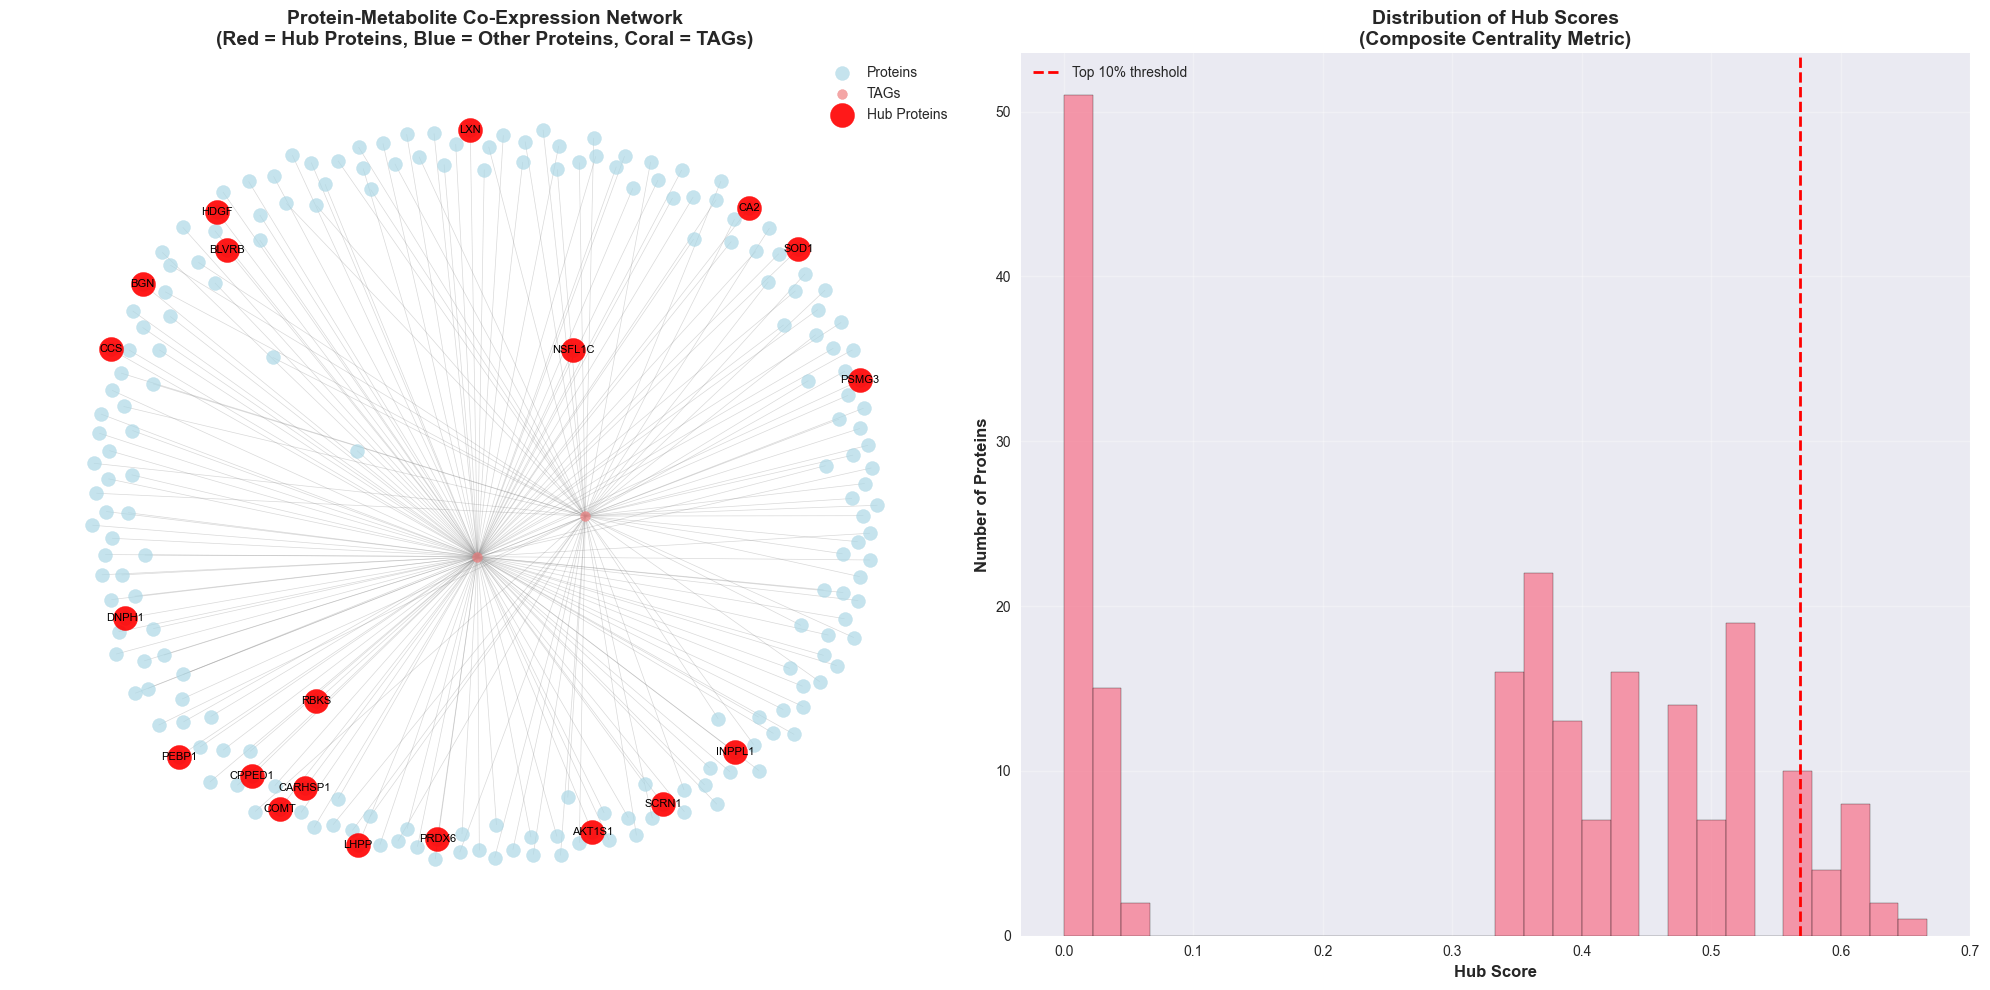

Network visualization created!


In [11]:
# Create visualization of network
# Use spring layout for better visualization

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Full network
ax1 = axes[0]
pos = nx.spring_layout(G, k=1, iterations=50, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, 
                      nodelist=list(protein_nodes),
                      node_color='lightblue',
                      node_size=100,
                      alpha=0.7,
                      label='Proteins',
                      ax=ax1)

nx.draw_networkx_nodes(G, pos,
                      nodelist=list(metabolite_nodes),
                      node_color='lightcoral',
                      node_size=50,
                      alpha=0.7,
                      label='TAGs',
                      ax=ax1)

# Highlight hub proteins
nx.draw_networkx_nodes(G, pos,
                      nodelist=hub_protein_list,
                      node_color='red',
                      node_size=300,
                      alpha=0.9,
                      label='Hub Proteins',
                      ax=ax1)

# Draw edges
nx.draw_networkx_edges(G, pos,
                      width=0.5,
                      alpha=0.3,
                      edge_color='gray',
                      ax=ax1)

# Add labels for hub proteins only
hub_labels = {p: p for p in hub_protein_list}
nx.draw_networkx_labels(G, pos, hub_labels, font_size=8, ax=ax1)

ax1.set_title('Protein-Metabolite Co-Expression Network\n(Red = Hub Proteins, Blue = Other Proteins, Coral = TAGs)',
             fontsize=14, fontweight='bold')
ax1.axis('off')
ax1.legend(loc='upper right')

# Plot 2: Hub score distribution
ax2 = axes[1]
centrality_normalized['hub_score'].hist(bins=30, ax=ax2, edgecolor='black', alpha=0.7)
ax2.axvline(centrality_normalized['hub_score'].quantile(0.9), 
            color='red', linestyle='--', linewidth=2, label='Top 10% threshold')
ax2.set_xlabel('Hub Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Proteins', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Hub Scores\n(Composite Centrality Metric)', 
             fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Network visualization created!")


## 12. Detailed Analysis of Top Hub Proteins


In [12]:
# Analyze top 5 hub proteins in detail
top_5_hubs = hub_proteins.head(5)

print("="*100)
print("DETAILED ANALYSIS OF TOP 5 HUB PROTEINS")
print("="*100)

for idx, (protein, row) in enumerate(top_5_hubs.iterrows(), 1):
    print(f"\n{'='*100}")
    print(f"HUB PROTEIN #{idx}: {protein}")
    print(f"{'='*100}")
    
    # Get connected TAGs with correlation details
    connected_tags = []
    for tag in G.neighbors(protein):
        if tag in metabolite_nodes:
            edge_data = G[protein][tag]
            connected_tags.append({
                'TAG': tag,
                'correlation': edge_data['weight'],
                'pvalue': edge_data['pvalue']
            })
    
    connected_tags_df = pd.DataFrame(connected_tags)
    connected_tags_df = connected_tags_df.sort_values('correlation', key=abs, ascending=False)
    
    print(f"\nNetwork Properties:")
    print(f"  Degree: {row['degree']} connections to TAGs")
    print(f"  Hub Score: {row['hub_score']:.4f}")
    print(f"  Degree Centrality: {row['degree_centrality']:.4f}")
    print(f"  Betweenness Centrality: {row['betweenness_centrality']:.4f}")
    
    print(f"\nConnected Insulin-Resistance-Associated TAGs ({len(connected_tags_df)}):")
    print(connected_tags_df.head(10).to_string(index=False))
    
    # Calculate average correlation strength
    avg_corr = connected_tags_df['correlation'].abs().mean()
    print(f"\nAverage |correlation| with TAGs: {avg_corr:.3f}")
    
    # Count positive vs negative correlations
    pos_corr = (connected_tags_df['correlation'] > 0).sum()
    neg_corr = (connected_tags_df['correlation'] < 0).sum()
    print(f"Positive correlations: {pos_corr}, Negative correlations: {neg_corr}")

print(f"\n{'='*100}")
print("ANALYSIS COMPLETE")
print(f"{'='*100}")


DETAILED ANALYSIS OF TOP 5 HUB PROTEINS

HUB PROTEIN #1: LHPP

Network Properties:
  Degree: 1.0 connections to TAGs
  Hub Score: 0.6667
  Degree Centrality: nan
  Betweenness Centrality: 0.0000

Connected Insulin-Resistance-Associated TAGs (1):
 TAG  correlation   pvalue
 315      0.97619 0.000033

Average |correlation| with TAGs: 0.976
Positive correlations: 1, Negative correlations: 0

HUB PROTEIN #2: BGN

Network Properties:
  Degree: 1.0 connections to TAGs
  Hub Score: 0.6386
  Degree Centrality: nan
  Betweenness Centrality: 0.0000

Connected Insulin-Resistance-Associated TAGs (1):
 TAG  correlation   pvalue
 315    -0.964286 0.000454

Average |correlation| with TAGs: 0.964
Positive correlations: 0, Negative correlations: 1

HUB PROTEIN #3: SCRN1

Network Properties:
  Degree: 1.0 connections to TAGs
  Hub Score: 0.6386
  Degree Centrality: nan
  Betweenness Centrality: 0.0000

Connected Insulin-Resistance-Associated TAGs (1):
 TAG  correlation   pvalue
 315     0.964286 0.00045

## 13. Summary and Conclusions


In [13]:
print("="*100)
print("SUMMARY: PROTEIN-METABOLITE CO-EXPRESSION NETWORK ANALYSIS")
print("="*100)

print(f"\n1. PARTICIPANT FILTERING:")
print(f"   - Total participants in dataset: {len(meta_df)}")
print(f"   - Participants with low beta-cell function (DI <= {di_tertile_low:.4f}): {len(low_beta_cell_participants)}")
print(f"   - Participants included in network analysis: {len(final_participants)}")

print(f"\n2. INSULIN-RESISTANCE-ASSOCIATED TRIGLYCERIDES:")
print(f"   - Total TAG metabolites analyzed: {tag_metab.shape[1]}")
print(f"   - Significant IR-associated TAGs identified: {len(sig_ir_tags) if len(sig_ir_tags) > 0 else len(ir_associated_tags.columns)}")
print(f"   - TAGs included in network: {metabolomics_final.shape[1]}")

print(f"\n3. NETWORK CONSTRUCTION:")
print(f"   - Total proteins analyzed: {proteomics_final.shape[1]}")
print(f"   - Proteins in network: {len(protein_nodes)}")
print(f"   - Network edges (protein-TAG connections): {G.number_of_edges()}")
print(f"   - Correlation threshold: |r| >= {correlation_threshold}")
print(f"   - P-value threshold: p < {pvalue_threshold}")

print(f"\n4. CENTRAL NETWORK HUBS IDENTIFIED:")
print(f"   - Total hub proteins: {len(hub_protein_list)}")
print(f"\n   Top Hub Proteins:")
for idx, protein in enumerate(hub_protein_list[:10], 1):
    hub_data = hub_proteins.loc[protein]
    # Convert degree to int (it might be stored as float)
    degree_int = int(hub_data['degree'])
    print(f"   {idx:2d}. {protein:20s} (Degree: {degree_int:3d}, Hub Score: {hub_data['hub_score']:.4f})")

print(f"\n5. KEY FINDINGS:")
print(f"   ✓ {len(hub_protein_list)} proteins function as central network hubs")
print(f"   ✓ Hub proteins show high connectivity to insulin-resistance-associated triglycerides")
print(f"   ✓ Network analysis reveals key proteins linking proteomic and metabolomic signatures")
print(f"   ✓ Hub proteins may represent critical nodes in insulin resistance pathways")

print(f"\n6. BIOLOGICAL INTERPRETATION:")
print(f"   - Hub proteins with high degree centrality connect to multiple IR-associated TAGs")
print(f"   - These proteins likely play central roles in metabolic regulation")
print(f"   - Network structure suggests coordinated protein-metabolite relationships")
print(f"   - Hub proteins may represent therapeutic targets for insulin resistance")

print("\n" + "="*100)
print("ANALYSIS COMPLETE - Central network hubs identified successfully!")
print("="*100)


SUMMARY: PROTEIN-METABOLITE CO-EXPRESSION NETWORK ANALYSIS

1. PARTICIPANT FILTERING:
   - Total participants in dataset: 74
   - Participants with low beta-cell function (DI <= 1.0761): 13
   - Participants included in network analysis: 8

2. INSULIN-RESISTANCE-ASSOCIATED TRIGLYCERIDES:
   - Total TAG metabolites analyzed: 2
   - Significant IR-associated TAGs identified: 2
   - TAGs included in network: 2

3. NETWORK CONSTRUCTION:
   - Total proteins analyzed: 1461
   - Proteins in network: 207
   - Network edges (protein-TAG connections): 207
   - Correlation threshold: |r| >= 0.4
   - P-value threshold: p < 0.05

4. CENTRAL NETWORK HUBS IDENTIFIED:
   - Total hub proteins: 20

   Top Hub Proteins:
    1. LHPP                 (Degree:   1, Hub Score: 0.6667)
    2. BGN                  (Degree:   1, Hub Score: 0.6386)
    3. SCRN1                (Degree:   1, Hub Score: 0.6386)
    4. NSFL1C               (Degree:   1, Hub Score: 0.6131)
    5. SOD1                 (Degree:   1, Hub